
--------------------------------------------------
BACKTEST RESULTS
--------------------------------------------------
Strategy Return: 121.58%
Buy & Hold Return: 1026.68%
Number of Trades: 366
Max Drawdown: -31.78%
--------------------------------------------------


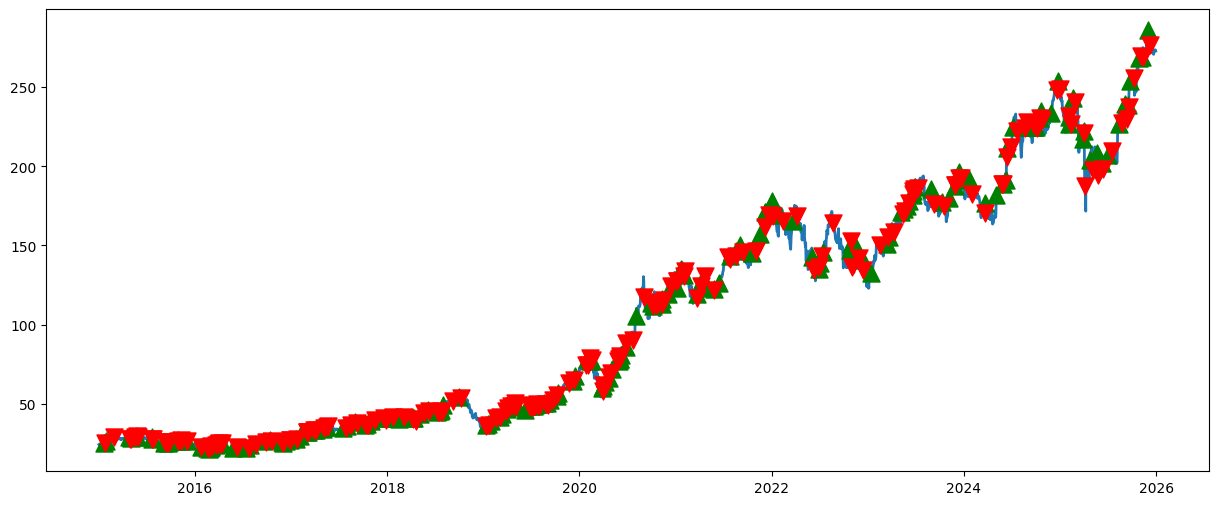

In [21]:

#import yfinance as yf - dont need causse backtest_function already has it
import pandas as pd
import matplotlib.pyplot as plt
from backtest_function import run_backtest

#create roc strategy function
def roc_strategy(prices: pd.Series, data: pd.DataFrame, params: dict) -> pd.Series:
    "Generate ROC signals: 1 = long, 0 = cash"
    roc_n = params.get('roc_n', 10) #10 day period - play around with this to see how it affects performance
    roc_threshold = params.get('roc_threshold', 3.0) #3% threshold, play around
    
    roc = ((prices - prices.shift(roc_n)) / prices.shift(roc_n)) * 100
    signal = (roc > roc_threshold).astype(int) # create series of true/false based on ROC to threshold, true =1,false = 0
    return signal

# run backtest
params = {'roc_n': 10, 'roc_threshold': 3.0} # dictionary of parameters to pass to strategy

trade_result = run_backtest(
    ticker='AAPL',
    start='2015-01-01',
    end='2025-12-31',
    strategy_fn=roc_strategy, #use strat function just created to decide when to be long or in cash
    strategy_params=params
)

# deliverables
total_return = (trade_result.results['ending_value_strategy'] / trade_result.results['initial_capital'] - 1) * 100
buyhold_return = (trade_result.results['ending_value_buyhold'] / trade_result.results['initial_capital'] - 1) * 100
num_trades = int(trade_result.results['trades'])
#just fetching the relevant metrics from the backtest results to print out in a nice format

print("\n" + "-"*50)
print("BACKTEST RESULTS")
print("-"*50)
print(f"Strategy Return: {total_return:.2f}%")
print(f"Buy & Hold Return: {buyhold_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Max Drawdown: {trade_result.results['max_drawdown_strategy']*100:.2f}%")
print("-"*50)

# Price Signals Plot
buy = result.position.diff() == 1
sell = trade_result.position.diff() == -1

plt.figure(figsize=(15, 6))
plt.plot(trade_result.prices.index, trade_result.prices, label='Price', linewidth=2)
plt.scatter(trade_result.prices[buy].index, trade_result.prices[buy], 
           marker='^', color='green', s=150, label='Buy', zorder=5)
plt.scatter(trade_result.prices[sell].index, trade_result.prices[sell],
           marker='v', color='red', s=150, label='Sell', zorder=5)


